# Predict The Stock Market With ML

We'll going to use S&P 500 and predict tomorrow's index price using 20 years of historical data. We will also backtesting if this is accurate prediction. After that we'll improve the model by adding predictors.

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import yfinance as yf
import pandas as pd

In [3]:
sp500 = yf.Ticker("^GSPC") # Download the Price History from Ticker class
sp500 = sp500.history(period = "max")

In [4]:
#sp500.index

<Axes: xlabel='Date'>

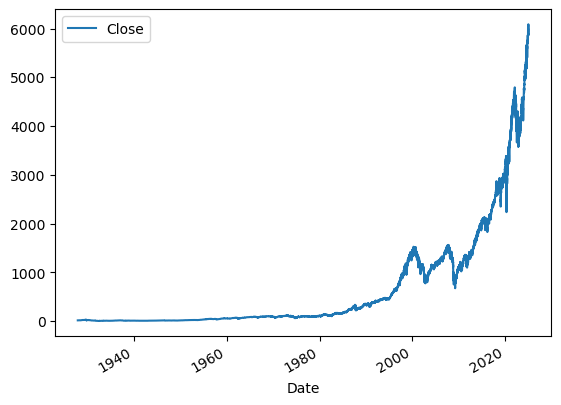

In [5]:
sp500.plot.line(y="Close", use_index = True)

In [6]:
#We are not going to use Dividends and Stock in this practice
del sp500["Dividends"]
del sp500["Stock Splits"]

In [7]:
#Shifting  -1 for every close of that day
sp500["Tomorrow"] = sp500["Close"].shift(-1) 

In [8]:
# If 1 then it going up and 0 or down
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [9]:
#sp500

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

### Training an Initial Machine Learning Model

In [11]:
# Simple ML Model. It help as a initial model since it's hard to be overfit than other models
from sklearn.ensemble import RandomForestClassifier

In [12]:
# Randomzation as 1 and split for 100 to avoid overfit, start with small # of estimators
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 100, random_state = 1)

# We can't use cross validation. Why? Time series nature of data (train works well but real world would be horrible)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

# We aren't going to use Tomorrow or Target since if we use that will cause overfit since it's already know the results
predictors = ["Close", "Volume", "Open", "High", "Low"]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=200, random_state=1)

In [13]:
# Verify the precision. How precise that we predict goes up actually stock price go up.
from sklearn.metrics import precision_score

preds = model.predict(test[predictors]) #array

In [14]:
preds = pd.Series(preds, index = test.index)

precision_score(test["Target"],preds)

0.7

We got precision as 70% which is good but we could make it better

<Axes: xlabel='Date'>

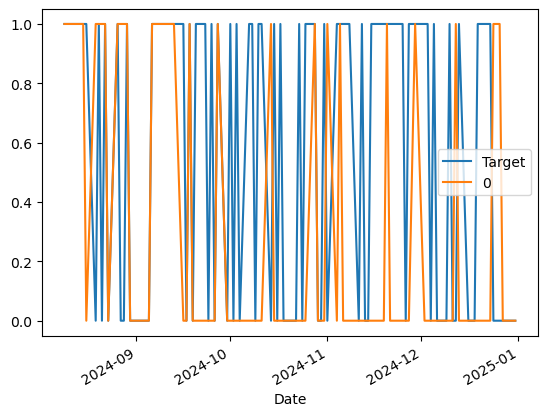

In [15]:
# Plot prediction
combined = pd.concat([test["Target"], preds], axis = 1) #axis = 1 so each test output will be as a column

combined.plot()

### Backtesting

In [16]:
# Similar as above but instead using train predictor as well.
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions") #Named the series as Predictions
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [17]:
# Training

#Training for 10 years where each business day is 250 days per year. 25000 days for 10 years
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step): #data.shape[0] -> # of rows
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
        
    return pd.concat(all_predictions)


In [18]:
#Call Back test
predictions = backtest(sp500, model, predictors)

predictions["Predictions"].value_counts()

Predictions
0    3628
1    2689
Name: count, dtype: int64

In [19]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5273335812569728

### Benchmark

In [20]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.535856
0    0.464144
Name: count, dtype: float64

Based on the Benchmark, 52.8% precision make it little worse than natural percentage of the days that stockmarket goes up. 

### Adding Additional Predictors

By adding more predictors check that whether the accuracy goes up or not.

In [21]:
horizons = [2, 5, 60, 250, 1000] #last 2 days, 5 days, 3 months, etc. 

#By checking for each span ratio, how long it goes up in that spans to help better prediction (hypothesis). 
new_predictors = []

for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean() # rolling() provide window (days span) calculation
    
    ratio_column = f"Close_Ratio_{horizon}" # create column name for each span
    sp500[ratio_column] = sp500["Close"] / rolling_avg["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"] # It will calculate the past days of the Target number so if 0 0 0 1 1 then would be for last 5 days there are 2 days that goes up
    
    new_predictors += [ratio_column, trend_column]

In [22]:
sp500 # There would be lot of NaN since if they can't find the enough days prior to the data, it will automatically become NaN

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24 00:00:00-05:00,5984.629883,6040.100098,5981.439941,6040.040039,1757720000,6037.589844,0,1.005491,2.0,1.017383,3.0,1.023002,35.0,1.115492,144.0,1.337188,531.0
2024-12-26 00:00:00-05:00,6024.970215,6049.750000,6007.370117,6037.589844,2904530000,5970.839844,0,0.999797,1.0,1.011334,3.0,1.021639,35.0,1.114008,143.0,1.335962,530.0
2024-12-27 00:00:00-05:00,6006.169922,6006.169922,5932.950195,5970.839844,3159610000,5906.939941,0,0.994441,0.0,0.996689,3.0,1.009600,34.0,1.100716,143.0,1.320543,529.0


In [23]:
# Fixing the NaN issues
sp500 = sp500.dropna()

### Improving Models

In [24]:
model =RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [25]:
# Similar as above but instead find the probability of the prediction
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #predict_proba. Probability the goes up
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    # Increase the chance that goes up
    
    preds = pd.Series(preds, index=test.index, name="Predictions") #Named the series as Predictions
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [26]:
# Backtest again
predictions = backtest(sp500, model, new_predictors)

In [27]:
predictions["Predictions"].value_counts()
#Why there's lot of 0's? 
#A: since we change the threshold to make it more confidence

Predictions
0.0    4463
1.0     853
Name: count, dtype: int64

In [29]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5756154747948418

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score

mae_test = mean_absolute_error(test["Target"],preds)
f1_test = f1_score(test["Target"], preds)

mae_new = mean_absolute_error(predictions["Target"], predictions["Predictions"])
f1_new = f1_score(predictions["Target"], predictions["Predictions"])

In [50]:
print(f"Mean Absolute Error: {mae_test}, F1 Score: {f1_test}")

Mean Absolute Error: 0.45, F1 Score: 0.48275862068965514


In [49]:
print(f"Mean Absolute Error: {mae_new}, F1 Score: {f1_new}")

Mean Absolute Error: 0.5212565838976674, F1 Score: 0.2616573407940314


## Conclusion

Adding more predictors does not always lead to better performance. In this case, the added predictors likely introduced noise or complexity, outweighing any potential benefits.